In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain.tools import Tool
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Optional
from langchain_core.messages import AIMessage, HumanMessage

In [2]:
import requests
from bs4 import BeautifulSoup
from docx import Document
from pypdf import PdfReader
import speech_recognition as sr
from gtts import gTTS
import tempfile
import docx
import PyPDF2

In [3]:
# LLMs
llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0.3)

In [4]:
# State Schema
class InterviewState(TypedDict):
    job_description: Optional[str]
    interviewer_url: Optional[str]
    company_url: Optional[str]
    jd_summary: Optional[str]
    resume_file_path: Optional[str]
    resume_text: Optional[str]
    resume_feedback: Optional[str]
    qa_chat_history: List[str]
    current_question: Optional[str]
    round: int

In [5]:
# === AGENT 1 ===
# Reviews JD, Interviewer, Company and summarizes

def fetch_webpage_text(url):
    try:
        response = requests.get(url=url)
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup.get_text()
    except:
        return "Could not fetch or parse the URL"
    
def agent1_review_web_sources(state:InterviewState)-> InterviewState:

    interviewer_profile = fetch_webpage_text(state['interviewer_url'])
    company_info = fetch_webpage_text(state['company_url'])

    jd_summary = llm.invoke(f"""
    Job Description: {state['job_description']}
    Interviewer LinkedIn Profile: {interviewer_profile}
    Company Info: {company_info}
    
    Summarize the role expectations, tech stake, interviewer background, Company focus, comapny values, and Interviewer's possible interests.""")

    state["jd_summary"] = jd_summary.content
    return state


In [6]:
# === AGENT 2 ===
# Reviews resume and gives feedback

def read_resume(file_path:str)-> str:
    if file_path.endswith(".pdf"):
        with open(file_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            return "\n".join([page.extract_text() for page in reader.pages])
    elif file_path.endswith(".docx"):
        doc = docx.Document(file_path)
        return "\n".join([para.text for para in doc.paragraphs])
    else:
        return "Unsupported File Format."
    

def agent2_resume_feedback(state:InterviewState)->InterviewState:
    resume_text = read_resume(state["resume_file_path"])
    state["resume_text"] = resume_text

    feedback = llm.invoke(f"""
    Resume:{resume_text}
    
    based on the job description summary below:
    {state['jd_summary']}
    
    Provide a detailed, constructive feedback on how to improve the resume for this role.
    """)

    state["resume_feedback"] = feedback.content
    return state


In [7]:
# === AGENT 3 ===
# Real-time Interview Agent

def agent3_interview_conversation(state:InterviewState)-> InterviewState:
    question_prompt = f"""
    Based on this summary:\n{state['jd_summary']}\n
    Ask a technical or behavioral interview question relevant for round {state['round']}"""

    question = llm.invoke(question_prompt).content
    print(f"\n🤖 Interviewer (Round {state['round']}): {question}")

    user_input = input("🧑 Candidate: ")
    feedback_prompt = f"""
    Interviewer asked: {question}
    Candidate answered: {user_input}
    Now, give detailed evaluation and an ideal answer with explanation."""

    feedback = llm.invoke(feedback_prompt).content
    print(f"\n🤖 Interviewer Feedback: {feedback}")

    state["qa_chat_history"]= state["qa_chat_history"].append([{"question": question, "answer": user_input, "feedback": feedback}])
    state["round"] = state["round"] + 1
    return state

In [9]:
workflow = StateGraph(InterviewState)

workflow.add_node("agent1_review_web_sources",agent1_review_web_sources)
workflow.add_node("agent2_resume_feedback",agent2_resume_feedback)
workflow.add_node("agent3_interview_conversation",agent3_interview_conversation)

workflow.set_entry_point("agent1_review_web_sources")
workflow.add_edge("agent1_review_web_sources","agent2_resume_feedback")
workflow.add_edge("agent2_resume_feedback","agent3_interview_conversation")

# Loop logic
total_rounds = 3

def should_continue(state: InterviewState):
    return "agent3_interview_conversation" if state["round"] <= total_rounds else END

workflow.add_conditional_edges("agent3_interview_conversation", should_continue)
# workflow.set_finish_point(END)

app = workflow.compile()


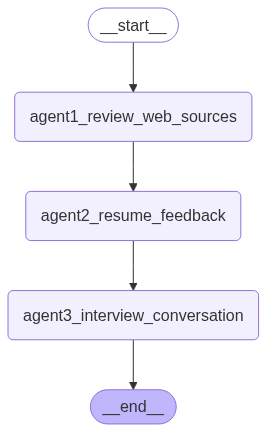

In [10]:
app